In [2]:
#----- imports --------

import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import wandb
import os
import tokenizers
from matplotlib import pyplot as plt
import numpy as np
import json
import random
import tqdm
from sae import TopKSparseAutoencoder


device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

torch.backends.cuda.matmul.allow_tf32 = True # for h100 gpu

config = {
    "learning_rate": 1e-2,
    # 'sae_size': 2**18,
    'sae_size': 2**14,
    "sae_topk": 20,
    "sae_learning_rate": 5e-5,
    "sae_sparsity_penalty": 250,
    "model_embedding_layer": 6,
    "eval_interval": 500,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 128,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "n_layers": 12,
    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v



# model_name = "tiny-stories-model-normal-0.44-loss.pt"
model_name = "tiny-stories-model-kurtosis-regularize-0.44-loss.pt"
residuals_path = f'./residuals/{model_name}'

sae_models_dir = 'sae_models'
if not os.path.exists(sae_models_dir):
    os.makedirs(sae_models_dir)
    print(f"Created directory: {sae_models_dir}")
else:
    print(f"Directory already exists: {sae_models_dir}")

model_path = f'{sae_models_dir}/sae-{model_name}'

!wandb disabled

# !wandb enabled
# wandb.init(
#    project = "scaling-monosemanticity-vanilla",
#    config = config,
# )

torch.Size([128, 1024])
Directory already exists: sae_models
W&B disabled.


In [3]:

a = torch.tensor([[1.25,2,3,4], # predicted example 1
                  [1.25,2.4,3.4,4.5]], dtype=torch.float32) # predicted example 2

b = torch.tensor([[1,   2,   3,   4  ], # actual example 1
                  [1.5, 2.5, 3.5, 4.5]], dtype=torch.float32) # actual example 2

def r2_per_channel(predicted, actual):
    channel_means = torch.mean(actual, dim=-2)
    avg_squared_error_per_channel = torch.mean((actual - channel_means)**2, dim=-2)
    avg_squared_error_predicted = torch.mean((predicted - actual)**2, dim=-2)
    return 1 - avg_squared_error_predicted / avg_squared_error_per_channel

print(r2_per_channel(a, b))

tensor([0.0000, 0.9200, 0.9200, 1.0000], device='cuda:0')


In [4]:
sample_feature_activations = torch.tensor(
    [
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 3, 0, 1],
        [1, 1, 0, 1]
    ]
)

def active_features_per_token(feature_activations):
    nonzero_counts = (feature_activations != 0).sum(dim=-1).to(torch.float32)
    return nonzero_counts

print(active_features_per_token(sample_feature_activations))

tensor([0., 1., 2., 3.], device='cuda:0')


In [5]:
sae = TopKSparseAutoencoder(C, sae_size, sae_topk)
optimizer = torch.optim.Adam(sae.parameters(), lr=sae_learning_rate)

In [6]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in sae.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8405504


In [7]:
def load_tensor(filepath):
    # load the .pt tensor
    tensor = torch.load(filepath)
    tensor = torch.cat(tensor, dim=0)
    tensor = tensor.to(device)
    return tensor
    

In [8]:
sae.forward(torch.randn(C))['mse']

tensor(0.5914, device='cuda:0', grad_fn=<MeanBackward0>)

In [9]:
# sae_path = 'sae_models/sae-tiny-stories-model-normal-0.44-loss.pt'


In [10]:
def random_rotation_matrix(n, dtype=torch.float32):
    """
    Generate a random rotation matrix in n dimensions.
    
    Args:
    n (int): Number of dimensions
    dtype (torch.dtype): Data type of the matrix
    device (str or torch.device): Device to create the matrix on
    
    Returns:
    torch.Tensor: An n x n random rotation matrix
    """
    # Generate a random matrix
    A = torch.randn(n, n, dtype=dtype)
    
    # Compute the QR factorization
    Q, R = torch.linalg.qr(A)
    
    # Ensure proper rotation matrix (determinant = 1)
    D = torch.diag(torch.sign(torch.diag(R)))
    Q = torch.mm(Q, D)
    
    return Q


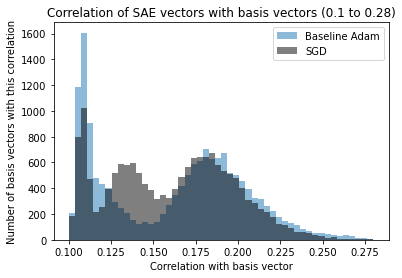

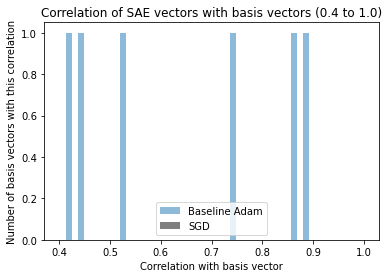

In [40]:
def analyze_sae_directions(sae_path, apply_rotation=True, normalize_weights=True):
    sae.load_state_dict(torch.load(sae_path, map_location='cuda'))
    
    if apply_rotation:
        rotation_matrix = random_rotation_matrix(C)
        encoder_weights = sae.encode.weight @ rotation_matrix
    else:
        encoder_weights = sae.encode.weight

    with torch.no_grad():
        if normalize_weights:
            norms = encoder_weights.norm(p=2, dim=-1, keepdim=True)
            encoder_weights = encoder_weights / norms
        
        encoder_weights = encoder_weights.abs()
        maxes, max_basis_dim = encoder_weights.max(dim=1)

        import matplotlib.pyplot as plt

        return {
            'max_basis_dimensions': max_basis_dim.cpu().numpy(),
            'max_correlations': maxes.cpu().numpy()
        }
        

# Example usage:
def plot_paired_sae_analysis(sae_path1, sae_path2, sae_name1, sae_name2, hist_range=(0.0, 1.0)):
    sae1_analysis = analyze_sae_directions(sae_path1, apply_rotation=False)
    sae2_analysis = analyze_sae_directions(sae_path2, apply_rotation=False)

    # plot both on a single histogram
    plt.hist(sae1_analysis['max_correlations'], bins=50, alpha=0.5, label=sae_name1, range=hist_range)
    plt.hist(sae2_analysis['max_correlations'], bins=50, alpha=0.5, label=sae_name2, range=hist_range, color='black')
    plt.legend()
    plt.xlabel('Correlation with basis vector')
    plt.ylabel('Number of basis vectors with this correlation')
    plt.title(f'Correlation of SAE vectors with basis vectors ({hist_range[0]} to {hist_range[1]})')
    plt.show()

def plot_sae_rotation_analysis(sae_path, hist_range=(0.0, 1.0)):
    sae_normal_direction_analysis = analyze_sae_directions(sae_path, apply_rotation=False)
    sae_direction_analysis_rotated = analyze_sae_directions(sae_path, apply_rotation=True)

    # plot both on a single histogram
    plt.hist(sae_normal_direction_analysis['max_correlations'], bins=50, alpha=0.5, label='Baseline Adam', range=hist_range)
    plt.hist(sae_direction_analysis_rotated['max_correlations'], bins=50, alpha=0.5, label='Random Rotation', range=hist_range)
    plt.legend()
    plt.xlabel('Correlation with basis vector')
    plt.ylabel('Number of basis vectors with this correlation')
    plt.title(f'Correlation of SAE vectors with basis vectors ({hist_range[0]} to {hist_range[1]})')
    plt.show()


# Example usage:
sae_kurtosis_path = 'sae_models/sae-tiny-stories-model-kurtosis-regularize-0.44-loss.pt'
sae_normal_path = 'sae_models/sae-6000.pt'
sae_sgd_path = 'sae_models/sae-tiny-stories-model-SGD-new.pt'

plot_paired_sae_analysis(sae_normal_path, sae_sgd_path, 'Baseline Adam', 'SGD', hist_range=(0.1, 0.28)) # default range is 0.0 to 1.0   
plot_paired_sae_analysis(sae_normal_path, sae_sgd_path, 'Baseline Adam', 'SGD', hist_range=(0.4, 1.0)) # default range is 0.0 to 1.0   

# To use a different range:
# plot_paired_sae_analysis(sae_normal_path, hist_range=(0.4, 1.0))

# analyze_sae_directions()



In [31]:
sae1_analysis = analyze_sae_directions(sae_normal_path, apply_rotation=False, normalize_weights=False)
maxes, max_basis_dim = sae1_analysis['max_correlations'], sae1_analysis['max_basis_dimensions']

winning_dimension_histogram = np.zeros(C)

for m, d in zip(maxes, max_basis_dim):
    if m > .41:
        print(f"Correlation: {m:.2f}, Basis dimension: {d}")
        


Correlation: 0.86, Basis dimension: 197
Correlation: 0.48, Basis dimension: 49
Correlation: 0.83, Basis dimension: 214
Correlation: 0.48, Basis dimension: 217
Correlation: 0.45, Basis dimension: 89
Correlation: 0.88, Basis dimension: 197
Correlation: 0.70, Basis dimension: 49


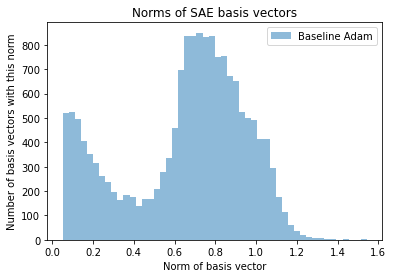

In [34]:
def analyze_sae_norms(sae_path, apply_rotation=True):
    sae.load_state_dict(torch.load(sae_path, map_location='cuda'))
    
    if apply_rotation:
        rotation_matrix = random_rotation_matrix(C)
        encoder_weights = sae.encode.weight @ rotation_matrix
    else:
        encoder_weights = sae.encode.weight
    

    with torch.no_grad():
        norms = encoder_weights.norm(p=2, dim=-1)
    return norms.cpu().numpy()

norms = analyze_sae_norms(sae_normal_path, apply_rotation=False)

plt.hist(norms, bins=50, alpha=0.5, label='Baseline Adam')

plt.legend()
plt.xlabel('Norm of basis vector')
plt.ylabel('Number of basis vectors with this norm')
plt.title('Norms of SAE basis vectors')
plt.show()

In [ ]:
        plt.figure(figsize=(12, 6))
        plt.hist(max_basis_dim.cpu().numpy(), bins=C, range=(0, C-1), edgecolor='black')
        plt.title('Histogram of Max Basis Dimensions')
        plt.xlabel('Basis Dimension')
        plt.ylabel('Frequency')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.hist(maxes.cpu().numpy(), bins=50, edgecolor='black')
        plt.title('Histogram of Correlation to Closest Basis Vector')
        plt.xlabel('Maximum Absolute Value')
        plt.ylabel('Frequency')
        plt.show()
